In [1]:
# https://course.fast.ai/videos/?lesson=10&t=3167 @52:46
# Callbacks
# keep track of metrics: progress bar animation
# hyper params scheduling 
# regularization techniques
# tensorboards
# mixed precision training


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pdb import set_trace
from functools import partial
import math

# Early Stopping

## Better callback cancellation

In [4]:
mnist = tf.keras.datasets.mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train.min(), y_train.max())
n, m = x_train.shape
c = y_train.max() + 1
print(n, m, c)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 784) (60000,) (10000, 784) (10000,) 0 9
60000 784 10


In [5]:
def normalize(x, m, s): return (x - m) / s

In [6]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(33.318421449829934, 78.56748998339798)

In [7]:
x_train = normalize(x_train, train_mean, train_std)
x_test  = normalize(x_test,  train_mean, train_std)

In [8]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(-3.064638490070051e-17, 0.9999999999999998)

In [9]:
class Model(tf.keras.Model):
    def __init__(self, nh, n_out):        
        super().__init__()
        self.lrs = [tf.keras.layers.Dense(nh), tf.keras.layers.ReLU(), tf.keras.layers.Dense(n_out)]
        
    def call(self, x):
        for l in self.lrs: x = l(x)
        return x
    
# corss entropy loss
def cross_entropy(targets, predictions):
    return tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(targets, predictions))

# here the target MUST NOT BE one hot encoded
def accuracy(targets, predictions):
    y_predictions = tf.cast(tf.argmax(predictions, axis=1), dtype=tf.float32)
    y_targets = tf.cast(targets, dtype=tf.float32)
    return tf.math.reduce_mean(tf.cast(tf.math.equal( y_predictions, y_targets) , dtype=tf.float32))

# class cross_entropy():
#     def __init__(self):
#         pass
    
#     def call(self, targets, predictions):
#         return tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(targets, predictions))

    

## Packing Your Full Model into a Learner

In [10]:
# The idea is to pack your model into something that take
# 1. the model 
# 2. the optimization method 
# 3. the loss function amd 4. the data
class Learner():
    def __init__(self, model, optimizer, loss_function, data):
        self.model, self.optimizer, self.loss_function, self.data = model, optimizer, loss_function, data

In [11]:
# The data as well can be packed into a DataBunch containing 
# 1. the training data
# 2. the validation data
# 3. the classes from 0 to 9
# in a future version it can be interesting to get a subsample of the full data
# for training purposes
class DataBunch():
    def __init__(self, train_dl, valid_dl, classes=None):
        self.train_dl, self.valid_dl, self.classes = train_dl, valid_dl, classes
        self.train_samples, self.valid_samples =  len(list(self.train_dl)), len(list(self.valid_dl))            

In [12]:
def one_hot(x, y, classes):
    return x, tf.one_hot(y, classes)

In [13]:
# Setting the dataset in tensorflow

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: one_hot(x, y, classes=c))

valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_ds = valid_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.map(lambda x, y: one_hot(x, y, classes=c))
train_ds, valid_ds

(<MapDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.float32)>,
 <MapDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.float32)>)

In [14]:
# Now how to fix this and insert callbacks: metrics and stuff

In [15]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

In [16]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):        
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):        
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):        
        self.run.n_epochs=self.epoch
#         self.model.train()
        self.run.in_train=True

    def begin_validate(self):        
#         self.model.eval()
        self.run.in_train=False
    
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [17]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [18]:
TrainEvalCallback().name

'train_eval'

In [19]:
#export
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [20]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):        
        cbs = listify(cbs)        
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def optimizer(self):       return self.learn.optimizer
    @property
    def model(self):           return self.learn.model
    @property
    def loss_function(self):   return self.learn.loss_function
    @property
    def data(self):            return self.learn.data

    def one_batch(self, xb, yb):        
        # if watch_accessed_variables is True, the variables will be watched for gradients computation
        # if watch_accessed_variables is False, no variables are watched for further gradients computation 
#         set_trace()
        with tf.GradientTape(watch_accessed_variables=self.in_train) as tape:   
            try:
                self.xb,self.yb = xb,yb
                self('begin_batch')
                # if training is True, this enables to calculate batchnorm and dropout
                # else batchnorm and dropout are disabled
                self.pred = self.model(self.xb, training=self.in_train)
                self('after_pred')
                self.loss = self.loss_function(self.yb, self.pred)            
                self('after_loss')
                if not self.in_train: return
                gradients = tape.gradient(self.loss, self.model.trainable_variables)
                self('after_gradients')
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                self('after_step')
            except CancelBatchException: self('after_cancel_batch')
            finally: self('after_batch')

    def all_batches(self, dl):        
        self.iters = len(list(dl))
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')                    

    def fit(self, epochs, learn):          
        self.epochs,self.learn = epochs,learn  
        
        try:  
            # set runner for all callbacks            
            for cb in self.cbs: cb.set_runner(self)     
                
            # on begin fit what to do?
            self('begin_fit')
            for epoch in range(epochs):                
                self.epoch = epoch
                # on begin epoch what to do?
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                
                # on begin validate what to do?                
                if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                    
                self('after_epoch')
                    
        except CancelTrainException: self('after_cancel_train')    
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

In [21]:
class LossAcc():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = metrics, in_train
        self.reset()
        
    def reset(self):
        self.tot_loss, self.tot_acc = 0., 0.
        
    def calculate(self, run):      
#         set_trace()
        self.tot_loss += run.loss.numpy()
        self.tot_acc  += self.metrics(tf.argmax(run.yb, axis=-1), run.pred).numpy()*100
    
#     def print_loss_acc(self, run):
#         print(self.tot_loss / run.data.valid_samples, self.tot_acc / run.data.valid_samples)
        
class LossAccCallback(Callback):
    def __init__(self, metrics):
        self.epoch = 0
        self.valid_lossacc = LossAcc(metrics, in_train=False)
        self.train_lossacc = LossAcc(metrics, in_train=True)
        
    def begin_epoch(self):        
        self.train_lossacc.reset()
        self.run.in_train=True
    
    def after_loss(self):
        if self.run.in_train:
            self.train_lossacc.calculate(self.run)
        else:
            self.valid_lossacc.calculate(self.run)
        
    def after_epoch(self):
        self.print_train(self.run)
        self.print_valid(self.run)
        self.epoch += 1
        
    def begin_validate(self):        
        self.valid_lossacc.reset()
        self.run.in_train=False
        
    def print_valid(self, run):
        print('Valid: ', 
              self.epoch, 
              self.valid_lossacc.tot_loss / run.data.valid_samples, 
              self.valid_lossacc.tot_acc / run.data.valid_samples)
        
    def print_train(self, run):
        print('Train: ', 
              self.epoch, 
              self.train_lossacc.tot_loss / run.data.train_samples, 
              self.train_lossacc.tot_acc / run.data.train_samples)

In [22]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [23]:
run = Runner(cb_funcs=TestCallback)

In [24]:
# set model parameters
n_out = 10 # output classes
nh = 50 # hidden
lr = 0.3
model = Model(nh, n_out)
loss_function = cross_entropy
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [25]:
# set the dataset
data = DataBunch(train_ds, valid_ds, classes=c)

In [26]:
# pack the full model into a learner
learn = Learner(model=model, optimizer=optimizer, loss_function=loss_function, data=data)

In [27]:
run.fit(3, learn)

W0130 14:36:22.925260 140032528676608 base_layer.py:1814] Layer model is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



0
1
2
3
4
5
6
7
8
9
10


In [43]:
# save and track of the loss and scheduled learning rate
class Recorder(Callback):    
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):        
        if not self.in_train: return        
        self.lrs.append(self.optimizer.lr.numpy())
        self.losses.append(self.loss.numpy())
        
    def plot_lr(self):                plt.plot(self.lrs)
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0):
        losses =[o.item() for o in self.losses]
        lrs = self.lrs
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [44]:
# schedule hyperparams
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): 
        self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):        
        if not hasattr(self.optimizer, self.pname): 
            print('No such attribute:', self.pname) 
            return
#         set_trace()
        setattr(self.optimizer, self.pname, self.sched_func(self.n_epochs/self.epochs))
        
    def begin_batch(self):
        if self.in_train: self.set_param()

In [45]:
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr)**pos
        setattr(self.optimizer, 'lr', lr)
        
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss        

In [46]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [56]:
# set model parameters
n_out = 10 # output classes
nh = 50 # hidden
lr = 0.25
model = Model(nh, n_out)
loss_function = cross_entropy
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [57]:
# set the dataset
data = DataBunch(train_ds, valid_ds, classes=c)

In [58]:
# pack the full model into a learner
learn = Learner(model=model, optimizer=optimizer, loss_function=loss_function, data=data)

In [59]:
run.fit(2, learn)

W0130 15:29:04.972650 140032528676608 base_layer.py:1814] Layer model_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



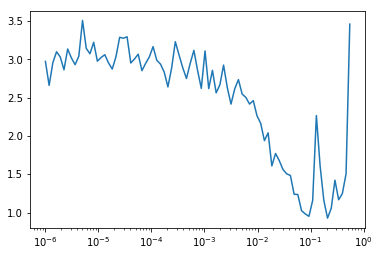

In [60]:
run.recorder.plot(skip_last=2)

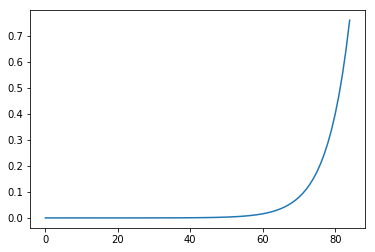

In [61]:
run.recorder.plot_lr()